In [2]:
# Make sure that you have all these libaries available to run the code successfully
import quandl
#from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from sklearn.metrics import mean_squared_error

# import pytz

Using TensorFlow backend.


In [28]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [13]:
# Here we only get the data in S&P 500
universe_df = pd.read_csv("sp500.csv")
universe = universe_df['Symbol'].tolist()
end_date = '2018-03-27'
begin_date = pd.Timestamp(end_date) - pd.DateOffset(months=24)
def get_stock_data(ticker):

    data_source = 'Yahoo Finance' # alphavantage or kaggle
    
    if data_source == 'Yahoo Finance':
        df = pd.read_csv("SP500_constitutes_modified.csv")
        df["Date"] = pd.to_datetime(df["Date"])
        df.set_index("Date", inplace = True)
        df = df[[ticker]]
        
    elif data_source == 'quantdl':
        # ====================== Loading Data from Quandl ==================================

        api_key = 'tv6mxJKZxRcTysJaHKc2'

        # Save data to this file
        file_to_save = 'stock_market_data-%s.csv'%ticker
        quandl.ApiConfig.api_key = api_key
         # If you haven't already saved data,
        # Go ahead and grab the data from the url
        # And store date, low, high, volume, close, open values to a Pandas DataFrame
        if not os.path.exists(file_to_save):
            df = quandl.get_table('WIKI/PRICES', qopts = { 'columns': ['date', 'close'] }, ticker = [ticker], date = { 'gte': '2016-03-27', 'lte': '2018-03-27' })        
            df.to_csv(file_to_save)
            
            # If the data is already there, just load it from the CSV
        else:
            print('File already exists. Loading data from CSV')
            df = pd.read_csv(file_to_save)
    else:
    
        # ====================== Loading Data from Kaggle ==================================
        # You will be using HP's data. Feel free to experiment with other data.
        # But while doing so, be careful to have a large enough dataset and also pay attention to the data normalization
        df = pd.read_csv(os.path.join('Stocks','hpq.us.txt'),delimiter=',',usecols=['Date','Open','High','Low','Close'])
        print('Loaded data from the Kaggle repository')
    
    return df

In [14]:
testing_pair = ['CME-US', 'ICE-US']
df_1 = get_stock_data('CME-US')
df_2 = get_stock_data('ICE-US')

In [15]:
close1 = df_1[testing_pair[0]].tolist()
close2 = df_2[testing_pair[1]].tolist()
date_all = df_1.index.tolist()
spread_close = [s1 - s2 for s1,s2 in zip(close1,close2)]
spread_df = pd.DataFrame(spread_close, index = date_all, columns = ['close']) 
spread_df

,close
2017-11-10,71.61
2017-11-13,73.07
2017-11-14,72.90
2017-11-15,73.14
2017-11-16,74.01
...,...
2019-11-22,113.15
2019-11-25,112.48
2019-11-26,111.40
2019-11-27,107.55


In [16]:
def create_dataset(dataset, look_back=1):

    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        dataX.append(dataset[i:(i+look_back),0])
        dataY.append(dataset[i+look_back,0])

    return np.array(dataX), np.array(dataY)


In [17]:
# for debugging

def load_data(data):
    #load data
    dataset = np.array(data['close'].values).reshape(-1,1)
    dataset = dataset.astype('float64')

    scaler = MinMaxScaler(feature_range=(0,1))
    dataset = scaler.fit_transform(dataset)

    # split into train and test sets
    train_size = int(len(dataset) * 0.67)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
    # reshape for look_back
    look_back = 10
    X_train, y_train = create_dataset(train, look_back) # look_back = lag
    X_test, y_test = create_dataset(test, look_back)

    # reshape for LSTM [samples, time steps, features]
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
    return X_train, X_test

In [20]:
X_train, X_test = load_data(spread_df)
X_train.shape

(334, 10, 1)

In [30]:
def LSTM_model(data):

    #load data
    dataset = np.array(data['close'].values).reshape(-1,1)
    dataset = dataset.astype('float64')

    scaler = MinMaxScaler(feature_range=(0,1))
    dataset = scaler.fit_transform(dataset)

    # split into train and test sets
    train_size = int(len(dataset) * 0.67)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
    # reshape for look_back
    look_back = 10
    X_train, y_train = create_dataset(train, look_back) # look_back = lag
    X_test, y_test = create_dataset(test, look_back)

    # reshape for LSTM [samples, time steps, features]
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    # LSTM
    model = Sequential()
    model.add(LSTM(32, input_dim=1)) #look_back))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train, nb_epoch=100, batch_size=5, verbose=2)

    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test) 
    
    # scale back 
    train_pred = scaler.inverse_transform(train_pred)
    y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
    test_pred = scaler.inverse_transform(test_pred)
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    # shift predictions for plotting
    train_pred_plot = np.empty_like(dataset)
    train_pred_plot[:,:] = np.nan
    train_pred_plot[look_back:len(train_pred)+look_back,:] = train_pred

    test_pred_plot = np.empty_like(dataset)
    test_pred_plot[:,:] = np.nan
    test_pred_plot[len(train_pred)+(look_back*2)+1:len(dataset)-1,:] = test_pred

    f = plt.figure()
    plt.plot(scaler.inverse_transform(dataset), color='b', lw=2.0, label='True Spread')
    plt.plot(train_pred_plot, color='g', lw=2.0, label='LSTM train')
    plt.plot(test_pred_plot, color='r', lw=2.0, label='LSTM test')
    plt.legend(loc=3)
    plt.grid(True)
    plt.show()
    return y_train, train_pred, y_test, test_pred

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(32, input_shape=(None, 1))`
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Epoch 1/100
 - 1s - loss: 0.0183
Epoch 2/100
 - 0s - loss: 0.0025
Epoch 3/100
 - 0s - loss: 0.0021
Epoch 4/100
 - 0s - loss: 0.0021
Epoch 5/100
 - 0s - loss: 0.0020
Epoch 6/100
 - 0s - loss: 0.0021
Epoch 7/100
 - 0s - loss: 0.0019
Epoch 8/100
 - 0s - loss: 0.0020
Epoch 9/100
 - 0s - loss: 0.0018
Epoch 10/100
 - 0s - loss: 0.0019
Epoch 11/100
 - 0s - loss: 0.0018
Epoch 12/100
 - 0s - loss: 0.0018
Epoch 13/100
 - 0s - loss: 0.0017
Epoch 14/100
 - 0s - loss: 0.0017
Epoch 15/100
 - 0s - loss: 0.0016
Epoch 16/100
 - 0s - loss: 0.0016
Epoch 17/100
 - 0s - loss: 0.0014
Epoch 18/100
 - 0s - loss: 0.0016
Epoch 19/100
 - 0s - loss: 0.0016
Epoch 20/100
 - 0s - loss: 0.0015
Epoch 21/100
 - 0s - loss: 0.0015
Epoch 22/100
 - 0s - loss: 0.0014
Epoch 23/100
 - 0s - loss: 0.0014
Epoch 24/100
 - 0s - loss: 0.0013
Epoch 25/100
 - 0s - loss: 0.0013
Epoch 26/100
 - 0s - loss: 0.0014
Epoch 27/100
 - 0s - loss: 0.0014
Epoch 28/100
 - 0s - loss: 0.0013
Epoch 29/100
 - 0s - loss: 0.0012
Epoch 30/100
 - 0s - lo

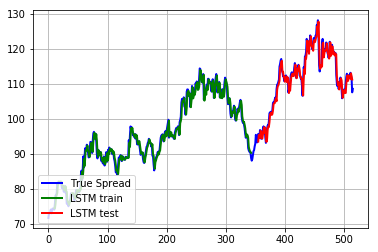

In [31]:
y_train, train_pred, y_test, test_pred = LSTM_model(spread_df)

In [32]:
error_test = list(np.array([real - test for test,real in zip(test_pred, y_test)]).flatten())
error_train = list(np.array([real - test for test,real in zip(train_pred, y_train)]).flatten())

In [68]:
# threshold = np.std(error_test) # to be improved

# computing moving threshold: 10-day moving standard deviation
window = 10
threshold = [100] * window
for i in range(window, len(y_test)):
    slice_spread = y_test[i - window: i]
    threshold.append(np.std(slice_spread))


In [75]:
threshold[-10:]

[1.830755308608992,
 2.0853153238779045,
 2.2076285919511025,
 2.1436501580248635,
 2.1250919980085614,
 1.9881006010763174,
 1.846488559401334,
 1.583522971099569,
 0.8387156848420118,
 0.59216636175994]

In [70]:
## build up backtesting system for 
# get the return list
close_list = list(y_test.flatten()) # y_test is true spread
return_list = [close1/close2 -1 for close1,close2 in zip(close_list[1:],close_list[:-1])]
signal = []
for i in range(len(close_list)):
    if error_test[i] < -1.5 * threshold[i]:
        signal.append(1)
    elif error_test[i] > 1.5 * threshold[i]:
        signal.append(-1)
    else:
        signal.append(0)

position_cursor = signal[0]
position = [signal[0]]
for i in range(1,len(signal)):
    if signal[i] != 0:
        if signal[i] != position[i-1]:
            position_cursor = signal[i]
    position.append(position_cursor)

In [71]:
position = position[:-1]
Capital_Line = [1]
Trading_Cost = 0.0015

for i in range(len(position)):
    if position[i] == 1:
        if i > 0 and position[i] != position[i-1]:
            Capital_Line.append(Capital_Line[i] * (1 + 1 * return_list[i] - Trading_Cost))
        else:
            Capital_Line.append(Capital_Line[i] * (1 +  1 * return_list[i]))
    else:
        if i > 0 and position[i] != position[i-1]:
            Capital_Line.append(Capital_Line[i] * (1 -1 * return_list[i] - Trading_Cost))
        else:
            Capital_Line.append(Capital_Line[i] * (1 -1 * return_list[i]))
            
train_size = int(len(date_all) * 0.67)
test_size = len(date_all) - train_size

date_train, date_test = date_all[0:train_size], date_all[train_size:len(date_all)]

#  Strategy Analysis
cul_return = Capital_Line[-1] - 1.0
date_line = range(len(date_test))
annual_rtn = pow(Capital_Line[-1], 250 / len(date_test)) - 1.0

# Log return
logR = [np.log(x + 1) for x in return_list]
annualVolatility = np.std(logR)
annualVolatility = annualVolatility / np.sqrt(1 / 250)
sharpe_ratio = annual_rtn / annualVolatility


In [72]:
len(Capital_Line)

160

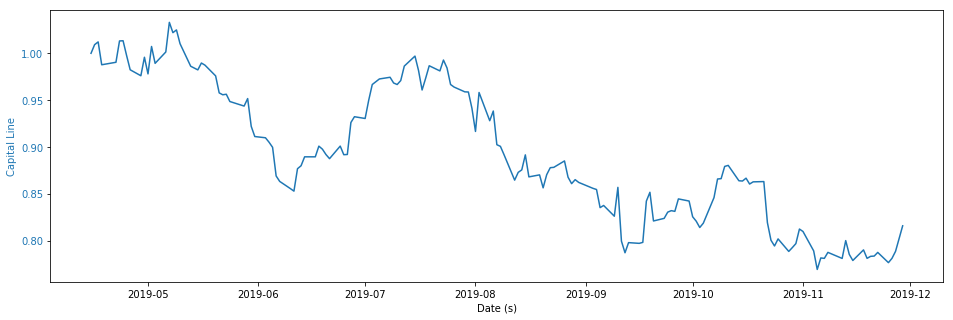

In [73]:
#register_matplotlib_converters()
fig, ax1 = plt.subplots(figsize=(16, 5))

color = 'tab:blue'
ax1.set_xlabel('Date (s)')
ax1.set_ylabel('Capital Line', color=color)
ax1.plot(date_test[11:], Capital_Line, color=color)
ax1.tick_params(axis='y', labelcolor=color)
plt.show()